In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
import datetime
load_dotenv()

True

In [2]:
llm_model = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash',
                                    temperature = 0,
                                    max_tokens=None,
                                    timeout=None,
                                    max_retries=2)

In [3]:
##Actor agent Prompt
##Actor is the main component -->> Subcomponents are 1. Response, Revisor
##chatprompt template is a list of tuples

##first instruction -->> example : write a blog post in 250 words (user query)
## 2nd instruction -->> reflect & critique the answer 
## 3rd instruction -->> provide search queries
actor_prompt_template = ChatPromptTemplate.from_messages([
    ("system",
     """ You are an expert AI researcher.
     Current time : {time}
     1. {first_instruction}
     2. Reflect and critique your answer. Be severe to maximize improvement.
     3. After the reflection, **list 1-3 search queries separately** for researching improvements. Do this separately, outside reflection step.
     """),
    MessagesPlaceholder(variable_name="messages"),
    #("system","Answer the user's question above using the required format")
]
).partial(time=lambda: datetime.datetime.now().isoformat()) ##dynamic time stamp, lambda doest need arguments

In [4]:
## LLM parser system : Response from unstructured LLM <<-->> structured Output ##
###schema###
from pydantic import BaseModel, Field
from typing import List

class Reflection(BaseModel):
    missing: str = Field(description='Critique of what is missing.')
    superflous: str = Field(description='Critique of what is superflous')

class AnswerQuestion(BaseModel):
    answer: str = Field(description="~250 word detailed answer to the question.")
    search_queries: List[str] = Field(description="1-3 search queries for researching the improvements to address,\
                                                    the critique of your current answer.")
    reflection: Reflection = Field(description = 'Your reflection on the initial answer')
    
    #### this field is itself an instance of Reflection base model ###
    #### internally convert to Relfection base model####
    '''
    Ex: data = AnswerQuestion(reflection={'missing':,search_queries:''}),
        which pydantic converts into
        data = AnswerQuestion(reflection = Reflection(missing=,search_queries=))
    '''
    ###Fields -->> Extra Metadata, Constraints for the field, gt,ge can be used, ... means required field

class ReviseAnswer(AnswerQuestion):
    ##inherited from AnswerQuestion class, with addition of references
    # answer: str = Field(description="~250 word detailed answer to the question.")
    # search_queries: List[str] = Field(description="1-3 search queries for researching the improvements to address,\
    #                                                 the critique of your current answer.")
    # reflection: Reflection = Field(description = 'Your reflection on the initial answer')
    references: List[str] = Field(description="Citations motivating your updated answer")
    

In [5]:
### responder chain
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
pydantic_parser = PydanticToolsParser(tools = [AnswerQuestion])
###Pydantic parser grounds the LLM output into the schema, does data validation(whether llm output follows the required format or not####
first_responder_prompt_template = actor_prompt_template.partial(first_instruction="Provide a detailed ~250 word answer")
first_responder_chain = first_responder_prompt_template | llm_model.bind_tools(tools=[AnswerQuestion],
                                                                        tool_choice='AnswerQuestion')
validator = pydantic_parser

In [6]:
response = first_responder_chain.invoke({"messages":[HumanMessage(content="Write a blog post in not more than 250 words on how,\
                                                                small businesses can leverage AI to grow")]
                                        })
print(response)

content='' additional_kwargs={'function_call': {'name': 'AnswerQuestion', 'arguments': '{"reflection": {"missing": "The blog post lacks specific examples of AI tools and their applications for small businesses. It also doesn\'t address the potential challenges and ethical considerations of using AI, such as data privacy and bias. Furthermore, it could benefit from a call to action, encouraging readers to explore specific AI solutions.", "superflous": "The introduction is a bit generic and could be more engaging. The conclusion is also somewhat weak and doesn\'t offer any concrete next steps."}, "answer": "## AI: The Small Business Game Changer\\n\\nSmall businesses often struggle to compete with larger corporations, but Artificial Intelligence (AI) is leveling the playing field. AI offers affordable solutions to boost efficiency, improve customer experience, and drive growth.\\n\\nOne key area is automation. AI-powered tools can automate repetitive tasks like data entry, scheduling, an

In [7]:
##execution of tools
import json
from typing import List, Dict, Any
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage, HumanMessage
from langchain_community.tools import TavilySearchResults

# Create the Tavily search tool
tavily_tool = TavilySearchResults(max_results=3)

def execute_tools(state:List[BaseMessage]) -> List[BaseMessage]:
    if isinstance(state[-1], AIMessage):
        last_ai_message : AIMessage = state[-1] ##getting the last AI message
        if not hasattr(last_ai_message,"tool_calls") or not last_ai_message.tool_calls:
            return []

        tool_messages = []
        for tool_call in last_ai_message.tool_calls:
            if tool_call["name"] in ["AnswerQuestion","ReviseAnswer"]:
                ##Call id required for context of which tool has been used###
                call_id = tool_call["id"]
                
                search_queries = tool_call["args"].get("search_queries",[])
    
                ###Execute each seach query with tavily search##
                query_res = {}
                for query in search_queries:
                    result = tavily_tool.invoke(query)
                    query_res[query] = result

                '''
                structure of the query_res
                {

                    "search_term1":[{"url":,"content":},{"url":,"content":},{"url":,"content":}]
                    "search_term2":[],
                    "search_term3":[]
                
                }
                
                '''
                tool_messages.append(
                        ToolMessage(
                            content = json.dumps(query_res),
                            tool_call_id = call_id,
                            tool_name = tool_call['name'] ##required for gemini
                        )
                    )
        return tool_messages

In [8]:
### test state in the workings ###
test_state = [
    HumanMessage(
        content="Write about how small business can leverage AI to grow"
    ),
    AIMessage(
        content="", 
        tool_calls=[
            {
                "name": "AnswerQuestion",
                "args": {
                    'answer': '', 
                    'search_queries': [
                            'AI tools for small business', 
                            'AI in small business marketing', 
                            'AI automation for small business'
                    ], 
                    'reflection': {
                        'missing': '', 
                        'superfluous': ''
                    }
                },
                "id": "call_KpYHichFFEmLitHFvFhKy1Ra",
            }
        ],
    )
]
'''
Flow of events: HumanMessage --> AIMessage --> UsesToolCall -->> We need the app flow to detect the tool call -->> App sends the toolMessage
to the message history-->> Example -->>
[
    HumanMessage(...),
    AIMessage(... with tool_calls),
    ToolMessage(...),  # Your tool's result
] 
-->>> Next AI agent with help of toolmessage and message history reasons and answers better finally
'''

"\nFlow of events: HumanMessage --> AIMessage --> UsesToolCall -->> We need the app flow to detect the tool call -->> App sends the toolMessage\nto the message history-->> Example -->>\n[\n    HumanMessage(...),\n    AIMessage(... with tool_calls),\n    ToolMessage(...),  # Your tool's result\n] \n-->>> Next AI agent with help of toolmessage and message history reasons and answers better finally\n"

In [9]:
##Running the test state###
resp = execute_tools(test_state)
resp

[ToolMessage(content='{"AI tools for small business": [{"url": "https://ddiy.co/best-ai-tools-small-business/", "content": "Frequently Asked Questions\\n--------------------------\\n\\n#### What are AI tools for small businesses?\\n\\nAI tools for small businesses are software solutions that use artificial intelligence to automate tasks, improve efficiency, and enhance decision-making across various business functions.\\n\\n#### Are AI tools expensive for small businesses?\\n\\nMany AI tools offer free plans or affordable pricing tiers, making them accessible to businesses of all sizes.\\n\\n#### Can AI tools improve customer service? [...] AI tools for small businesses are software apps powered by artificial intelligence that help do everything from streamlining operations to improving efficiency and even enhancing decision-making. [...] Table of Contents \\\\[hide\\\\]\\n\\n   Our Favorite AI Tools for Small Businesses\\n   How We Chose These Tools for Small Businesses\\n   1\\\\. Hu

In [11]:
### Revisor Chain ##
revise_instructions = """Revise your previous answer using the new information.
 - You should use the previous critique to add important information to ypur answer.
 - You *MUST* include numerous citations in your answer to ensure it can be verified. For the citations,\
   Add a "References" section at the bottom of your answer (this should not count towards the word limit). In the form of:
                 a. https://example1.com
                 b. https://example2.com
 - You should use the previous critique to remove the suoerflous information from your answer, and make sure the word limit of,\
     250 words is maintained
"""
revisor_prompt_template = actor_prompt_template.partial(first_instruction = revise_instructions)
revisor_chain = revisor_prompt_template | llm_model.bind_tools(tools=[ReviseAnswer],tool_choice="ReviseAnswer") 

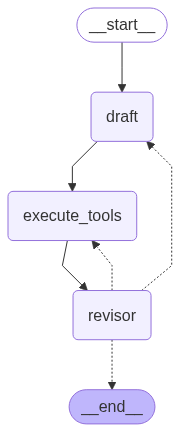

In [12]:
### reflexion graph
from langgraph.graph import END, MessageGraph
graph = MessageGraph()
MAX_ITERATIONS = 2
### Nodes ##
graph.add_node("draft",first_responder_chain) ## node for the responder
graph.add_node("execute_tools",execute_tools)
graph.add_node("revisor",revisor_chain)

graph.add_edge("draft","execute_tools")
graph.add_edge("execute_tools","revisor")

def event_loop(state:List[BaseMessage])->str:
    count_tool_visits = sum(isinstance(item,ToolMessage) for item in state) ##count the number of ToolMessage in the state list
    num_iterations = count_tool_visits
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"

graph.add_conditional_edges("revisor",event_loop)
graph.set_entry_point("draft")
app = graph.compile()
from IPython.display import Image, display
png = app.get_graph().draw_mermaid_png()
display(Image(png))

In [13]:
response = app.invoke("Write about how small business can leverage AI to grow")

In [15]:
response

[HumanMessage(content='Write about how small business can leverage AI to grow', additional_kwargs={}, response_metadata={}, id='9d429ced-024d-482a-8f13-d285e2d1d1b8'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'AnswerQuestion', 'arguments': '{"reflection": {"missing": "The answer lacks specific examples of AI tools and their applications in small businesses. It also doesn\'t address the challenges of AI adoption, such as lack of technical expertise and data availability. The answer could also benefit from discussing the importance of choosing the right AI solutions based on the specific needs and resources of the small business.", "superflous": "The answer is slightly repetitive in emphasizing the benefits of AI and the importance of data-driven decisions."}, "answer": "Small businesses can leverage AI in numerous ways to drive growth. One key area is marketing. AI-powered tools can analyze customer data to personalize marketing campaigns, optimize ad spending

In [14]:
print(response[-1].tool_calls[0]["args"]["answer"])

Small businesses can leverage AI to drive growth [1]. In marketing, AI tools like HubSpot AI and Jasper personalize campaigns and automate content [2]. Chatbots improve customer support [1]. AI identifies leads and predicts behavior for sales [1]. Semrush aids SEO and content marketing [2]. AI optimizes inventory, supply chain, and predicts equipment failures [1, 4]. It assists with sentiment analysis and training [4]. Upmetrics helps generate business plans [4]. AI-driven analytics offer insights [1].

However, AI adoption presents challenges: costs and lack of expertise [3]. Businesses should define goals and address pain points [1]. Prioritize data privacy and ethical AI [1]. Ethical considerations include fairness, transparency, and accountability; develop an AI ethics policy [5]. Choose user-friendly, integrable tools [3]. Train employees for ROI [1]. Be aware of risks like algorithmic bias and security threats [6]. Algorithmic bias can lead to unfair outcomes [6]. Security threat

In [16]:
print(response[-1].tool_calls[0]["args"]["references"])

['https://fitsmallbusiness.com/best-ai-marketing-tools/', 'https://www.uschamber.com/co/grow/marketing/ai-tools-for-small-business-marketing', 'https://sudeepbanerjee.com/ai-adoption-in-small-businesses-opportunities-and-challenges/', 'https://ossisto.com/blog/ai-tools-for-small-businesses/', 'https://www.movingforwardsmallbusiness.com/mastering-ai-ethics-small-business-operation-strategies/', 'https://www.cybersecurityintelligence.com/blog/rising-ai-security-threats-to-small-businesses-7752.html']
